In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [2]:
df_meta = pd.read_parquet("./data/meps_2023/meps_2023_meta.parquet")
model = joblib.load("./data/models/logreg_hospitalization.pkl")

In [3]:
# Renaming the categorical variables based on the official MEPS category definitions for the variables


sex_map = {1: "Male", 2: "Female"}

race_eth_map = {1: "White", 2: "Black", 3: "Hispanic", 4: "Asian", 5: "Other"}

poverty_map = {
    1: "Poor",
    2: "Near Poor",
    3: "Low Income",
    4: "Middle Income",
    5: "High Income",
}

insurance_map = {1: "Any Private", 2: "Public Only", 3: "Uninsured"}

#### Quick Sanity Checks

In [4]:
# Basic info and columns
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18919 entries, 0 to 18918
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   person_id                 18919 non-null  object 
 1   age                       18919 non-null  int64  
 2   sex                       18919 non-null  int64  
 3   race_ethnicity            18919 non-null  int64  
 4   hispanic                  18919 non-null  int64  
 5   poverty_category          18919 non-null  int64  
 6   insurance_coverage        18919 non-null  int64  
 7   family_income             18919 non-null  int64  
 8   self_rated_health         18919 non-null  int64  
 9   self_rated_mental_health  18919 non-null  int64  
 10  hospitalized              18919 non-null  float64
 11  pred_prob                 18919 non-null  float64
 12  pred_label                18919 non-null  float64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.9+ MB
None

In [5]:
print(df_meta.describe(include="all").T.head(20))

                            count unique         top freq          mean  \
person_id                   18919  18919  2790002101    1           NaN   
age                       18919.0    NaN         NaN  NaN     43.716581   
sex                       18919.0    NaN         NaN  NaN      1.523601   
race_ethnicity            18919.0    NaN         NaN  NaN      2.148052   
hispanic                  18919.0    NaN         NaN  NaN      1.778635   
poverty_category          18919.0    NaN         NaN  NaN       3.70897   
insurance_coverage        18919.0    NaN         NaN  NaN      1.485068   
family_income             18919.0    NaN         NaN  NaN  98815.895555   
self_rated_health         18919.0    NaN         NaN  NaN      2.259263   
self_rated_mental_health  18919.0    NaN         NaN  NaN      2.159416   
hospitalized              18919.0    NaN         NaN  NaN      0.073735   
pred_prob                 18919.0    NaN         NaN  NaN      0.246317   
pred_label               

In [6]:
# Check outcome and prediction distributions
print("Outcome distribution (hospitalized):")
print(df_meta["hospitalized"].value_counts(normalize=True))

print("\nPredicted label distribution:")
print(df_meta["pred_label"].value_counts(normalize=True))

print("\nPredicted probability summary:")
print(df_meta["pred_prob"].describe())

Outcome distribution (hospitalized):
hospitalized
0.0    0.926265
1.0    0.073735
Name: proportion, dtype: float64

Predicted label distribution:
pred_label
0.0    0.849305
1.0    0.150695
Name: proportion, dtype: float64

Predicted probability summary:
count    18919.000000
mean         0.246317
std          0.262997
min          0.001380
25%          0.085945
50%          0.131678
75%          0.267566
max          1.000000
Name: pred_prob, dtype: float64


This all seems correct. Our data has been imported correctly.

## Mapping the categorical features

In [7]:
df_meta["sex"] = df_meta["sex"].map(sex_map)
df_meta["race_ethnicity"] = df_meta["race_ethnicity"].map(race_eth_map)
df_meta["poverty_category"] = df_meta["poverty_category"].map(poverty_map)
df_meta["insurance_coverage"] = df_meta["insurance_coverage"].map(insurance_map)

In [8]:
def fairness_table(df, group_col):
    # Returns mean true rate, predicted label rate, and avg predicted prob
    return (
        df.groupby(group_col)[["hospitalized", "pred_label", "pred_prob"]]
        .mean()
        .rename(
            columns={
                "hospitalized": "true_rate",
                "pred_label": "predicted_rate",
                "pred_prob": "avg_pred_prob",
            }
        )
        .sort_index()
    )


def disparity(df, group_col):
    # Simple difference between max and min values across groups
    tbl = fairness_table(df, group_col)
    return tbl.max() - tbl.min()

In [9]:
group_cols = ["sex", "race_ethnicity", "poverty_category", "insurance_coverage"]

for g in group_cols:
    print(f"\n=== Fairness for {g} ===")
    display(fairness_table(df_meta, g))


=== Fairness for sex ===


,true_rate,predicted_rate,avg_pred_prob
sex,,,
Female,0.082172,0.179689,0.282137
Male,0.064462,0.118828,0.206948



=== Fairness for race_ethnicity ===


,true_rate,predicted_rate,avg_pred_prob
race_ethnicity,,,
Asian,0.039130,0.083478,0.188228
Black,0.085703,0.174018,0.264896
Hispanic,0.083333,0.177778,0.274717
Other,0.060858,0.124481,0.222625
White,0.050143,0.099809,0.203406



=== Fairness for poverty_category ===


,true_rate,predicted_rate,avg_pred_prob
poverty_category,,,
High Income,0.060799,0.123629,0.217075
Low Income,0.083702,0.173038,0.271182
Middle Income,0.065884,0.129496,0.226138
Near Poor,0.112849,0.237989,0.322201
Poor,0.100627,0.212744,0.313457



=== Fairness for insurance_coverage ===


,true_rate,predicted_rate,avg_pred_prob
insurance_coverage,,,
Any Private,0.057337,0.110507,0.200820
Public Only,0.111989,0.241605,0.338747
Uninsured,0.019260,0.031587,0.164650


In [10]:
def plot_fairness(df, group_col):
    tbl = fairness_table(df, group_col)
    ax = tbl[["true_rate", "avg_pred_prob"]].plot(kind="bar", figsize=(7, 4))
    ax.set_title(f"True vs Predicted Risk by {group_col}")
    plt.tight_layout()
    plt.show()

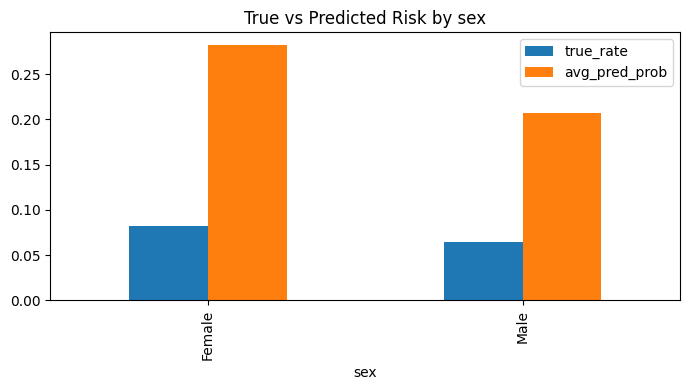

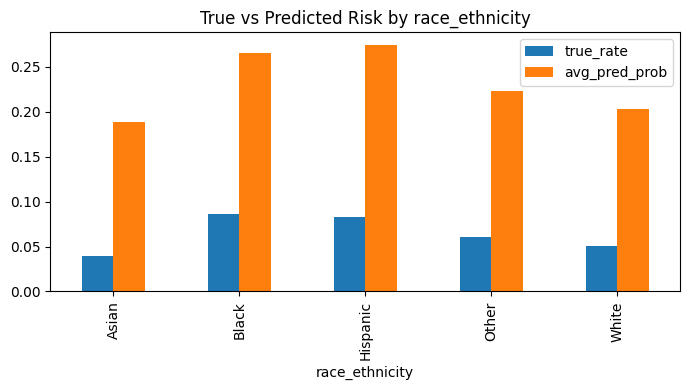

In [11]:
plot_fairness(df_meta, "sex")
plot_fairness(df_meta, "race_ethnicity")